In [1]:
import os, sys
# ensure project root is on PYTHONPATH
ROOT = os.path.abspath("..")       # adjust if needed
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

from task_dataset import TaskDataset

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import sys
import os

# Set paths
EMB_PATH = "F:\\TML_model_stealing\\TML25_A2_39\\data\\public_embeddings_seed61437433_port9732.npz"
IMG_PATH = "F:\\TML_model_stealing\\TML25_A2_39\\data\\ModelStealingPub.pt"

print("Loading from:")
print(" - Embeddings:", EMB_PATH)
print(" - Images:", IMG_PATH)


Loading from:
 - Embeddings: F:\TML_model_stealing\TML25_A2_39\data\public_embeddings_seed61437433_port9732.npz
 - Images: F:\TML_model_stealing\TML25_A2_39\data\ModelStealingPub.pt


In [ ]:
#-----------------------------------------------

## Train base encoder with victim representations

In [4]:
# Load the victim .npz
data = np.load(EMB_PATH)
indices = data["indices"]
reps = data["reps"]
seed = int(data["seed"])
port = int(data["port"])

print("Loaded embeddings:", reps.shape)

# Load the corresponding public image dataset (.pt)
dataset = torch.load(IMG_PATH, weights_only=False)
images  = [dataset.imgs[i] for i in indices]

# Ensure length matches
assert len(images) == reps.shape[0]
print("Loaded matching images:", len(images))


Loaded embeddings: (1000, 1024)
Loaded matching images: 1000


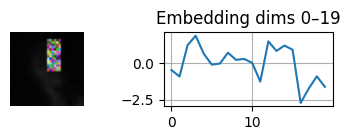

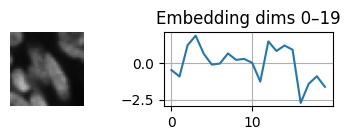

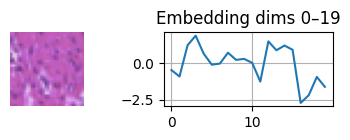

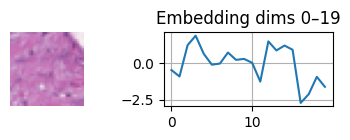

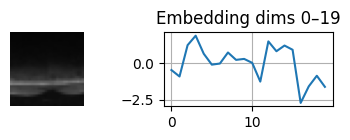

In [5]:
# Show first 5 images and their first 20 embedding dims
for i in range(5):
    img = images[i]
    emb = reps[i]

    plt.figure(figsize=(4, 1.5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.plot(emb[:20])
    plt.title("Embedding dims 0–19")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [6]:
# Define Stolen Encoder Architecture

import torch
import torch.nn as nn
from torchvision.models import resnet18

class StolenEncoder(nn.Module):
    def __init__(self, pretrained_backbone=False):
        super().__init__()
        # 1) Backbone
        self.backbone = resnet18(pretrained=pretrained_backbone)
        # Remove the original classification head
        self.backbone.fc = nn.Identity()
        # 2) Projection head to get 1024-dim outputs
        self.proj = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1024)
        )

    def forward(self, x):
        # x shape: (B,3,32,32)
        feat = self.backbone(x)     # (B,512)
        rep  = self.proj(feat)      # (B,1024)
        return rep

# Quickly test shape
model = StolenEncoder(pretrained_backbone=False)
x = torch.randn(4, 3, 32, 32)
y = model(x)
print("➡️ StolenEncoder output shape:", y.shape)


➡️ StolenEncoder output shape: torch.Size([4, 1024])


c:\Users\srtol\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\srtol\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Basic transforms to convert PIL → Tensor + normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

class StealingDataset(Dataset):
    def __init__(self, images, embeddings, transform=None):
        """
        images: list of PIL.Image
        embeddings: numpy array (N,1024)
        """
        self.images     = images
        self.embeddings = torch.from_numpy(embeddings).float()
        self.transform  = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if img.mode != 'RGB':
            img = img.convert("RGB")
        if self.transform:
            img = self.transform(img)
        rep = self.embeddings[idx]
        return img, rep


# Instantiate dataset & dataloader
dataset_ssl = StealingDataset(images, reps, transform=transform)
loader_ssl  = DataLoader(dataset_ssl, batch_size=64, shuffle=True, num_workers=2)

print("Dataset size:", len(dataset_ssl))
# print("One batch shapes:", next(iter(loader_ssl))[0].shape, next(iter(loader_ssl))[1].shape)


Dataset size: 1000


In [8]:
# Set up training components

import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = StolenEncoder(pretrained_backbone=False).to(device)

# Loss: MSE between student & victim embeddings
criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# (Optional) learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


Using device: cpu


In [ ]:
# Train for one epoch & log loss

model.train()
running_loss = 0.0

for batch_idx, (imgs, target_reps) in enumerate(loader_ssl, 1):
    imgs = imgs.to(device)                  # (B,3,32,32)
    target_reps = target_reps.to(device)    # (B,1024)

    optimizer.zero_grad()
    pred_reps = model(imgs)                 # (B,1024)
    loss = criterion(pred_reps, target_reps)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if batch_idx % 50 == 0:
        print(f"  [Batch {batch_idx}] Avg Loss: {running_loss / batch_idx:.4f}")

# Step the scheduler
scheduler.step()

epoch_loss = running_loss / len(loader_ssl)
print(f"→ Epoch Loss: {epoch_loss:.4f}")


## SimCLR

#### Imports and setup

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

# Path to victim embeddings and image dataset
EMB_PATH = "F:\\TML_model_stealing\\TML25_A2_39\\data\\public_embeddings_seed61437433_port9732.npz"
IMG_PATH = "F:\\TML_model_stealing\\TML25_A2_39\\data\\ModelStealingPub.pt"


In [4]:
# Load victim embeddings and image indices
data = np.load(EMB_PATH)
reps = data["reps"]       # shape: (N,1024)
indices = data["indices"]

In [5]:
# Load full dataset and extract relevant images
full_dataset = torch.load(IMG_PATH, weights_only=False)
images = [full_dataset.imgs[i] for i in indices]

print(f"Loaded {len(images)} images and {reps.shape[0]} victim embeddings")

Loaded 1000 images and 1000 victim embeddings


#### Define Augmentations and Dataset

In [6]:
# SimCLR augmentations (strong)
simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [7]:
# Dataset class returning two views + victim rep
class SimCLRDataset(Dataset):
    def __init__(self, images, victim_reps, transform):
        self.images = images
        self.vreps = torch.from_numpy(victim_reps).float()
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if img.mode != 'RGB':
            img = img.convert("RGB")
        t1 = self.transform(img)
        t2 = self.transform(img)
        rep = self.vreps[idx]
        return t1, t2, rep

#### Visualize Augmentations

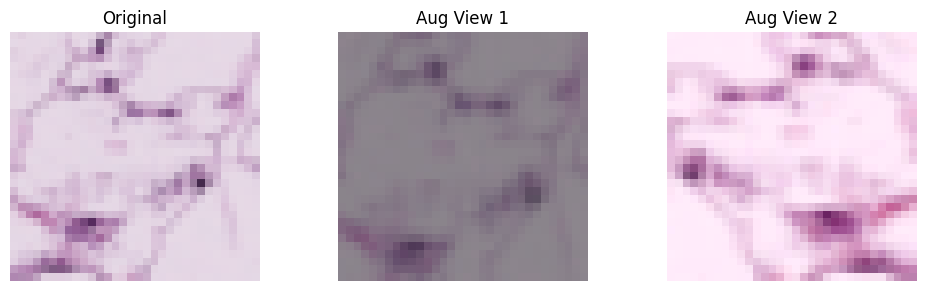

In [8]:
# Show original image and two augmented views
img_example = images[9]
aug1 = simclr_transform(img_example)
aug2 = simclr_transform(img_example)

# Convert tensors back to image format for display
def deprocess(t):
    t = t.clone().detach().permute(1,2,0)
    t = t * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    return t.clamp(0, 1).numpy()

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.imshow(img_example)
plt.title("Original")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(deprocess(aug1))
plt.title("Aug View 1")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(deprocess(aug2))
plt.title("Aug View 2")
plt.axis('off')
plt.tight_layout()
plt.show()

#### Define Encoder Model

In [9]:
from torchvision.models import resnet18

class StolenEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = resnet18(pretrained=False)
        self.backbone.fc = nn.Identity()
        self.head = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1024)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

Options to train the model with respective loss

#### Train SimCLR Loop with MSE loss

c:\Users\srtol\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\srtol\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[Epoch 1] Loss: 0.5718
[Epoch 2] Loss: 0.1525
[Epoch 3] Loss: 0.0406
[Epoch 4] Loss: 0.0141
[Epoch 5] Loss: 0.0071
[Epoch 6] Loss: 0.0048
[Epoch 7] Loss: 0.0039
[Epoch 8] Loss: 0.0034
[Epoch 9] Loss: 0.0029
[Epoch 10] Loss: 0.0025
[Epoch 11] Loss: 0.0024
[Epoch 12] Loss: 0.0022
[Epoch 13] Loss: 0.0020
[Epoch 14] Loss: 0.0020
[Epoch 15] Loss: 0.0019
[Epoch 16] Loss: 0.0018
[Epoch 17] Loss: 0.0017
[Epoch 18] Loss: 0.0017
[Epoch 19] Loss: 0.0017
[Epoch 20] Loss: 0.0016


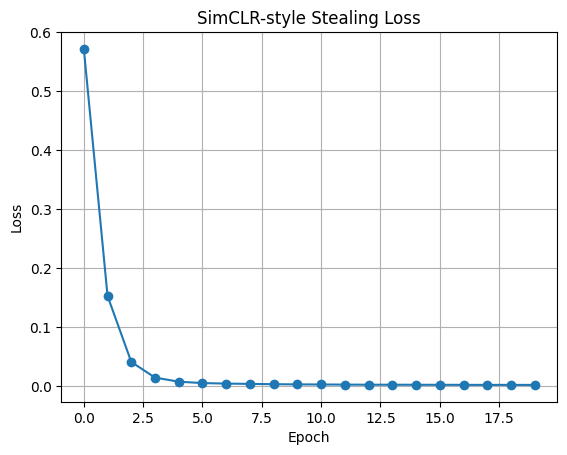

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StolenEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loader = DataLoader(SimCLRDataset(images, reps, simclr_transform), batch_size=64, shuffle=True)

alpha = 0.9  # weight between victim alignment and self-consistency
num_epochs = 20
loss_history = []

for epoch in range(1, num_epochs+1):
    model.train()
    total = 0
    for t1, t2, yv in loader:
        t1, t2, yv = t1.to(device), t2.to(device), yv.to(device)

        optimizer.zero_grad()
        o1 = model(t1)         # (B,1024)
        o2 = model(t2)         # (B,1024)
        loss_A = F.mse_loss(o1, yv)
        loss_B = F.mse_loss(o2, o1.detach())
        loss = alpha * loss_A + (1 - alpha) * loss_B              # contrastive/old loss/MSE aggregated loss
        loss.backward()
        optimizer.step()
        total += loss.item()

    avg = total / len(loader)
    loss_history.append(avg)
    print(f"[Epoch {epoch}] Loss: {avg:.4f}")

# Plot training loss
plt.plot(loss_history, marker='o')
plt.title("SimCLR-style Stealing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


-------------
#### OR

#### Train SimCLR with cosine similarity loss

c:\Users\srtol\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\srtol\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[Epoch 1] Loss: 0.5221
[Epoch 2] Loss: 0.1259
[Epoch 3] Loss: 0.0312
[Epoch 4] Loss: 0.0116
[Epoch 5] Loss: 0.0063
[Epoch 6] Loss: 0.0045
[Epoch 7] Loss: 0.0035
[Epoch 8] Loss: 0.0030
[Epoch 9] Loss: 0.0027
[Epoch 10] Loss: 0.0024
[Epoch 11] Loss: 0.0022
[Epoch 12] Loss: 0.0020
[Epoch 13] Loss: 0.0019
[Epoch 14] Loss: 0.0018
[Epoch 15] Loss: 0.0018
[Epoch 16] Loss: 0.0017
[Epoch 17] Loss: 0.0017
[Epoch 18] Loss: 0.0017
[Epoch 19] Loss: 0.0016
[Epoch 20] Loss: 0.0016


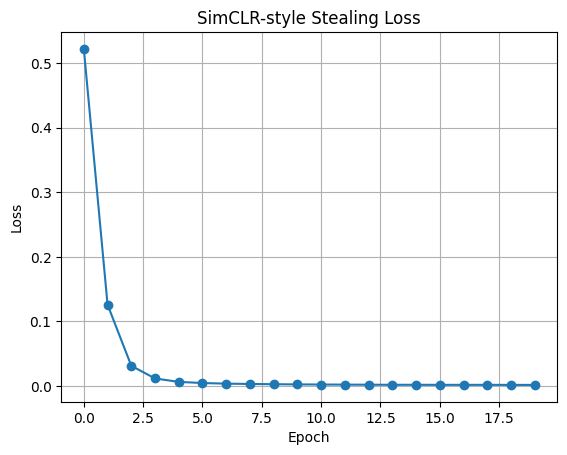

In [10]:
def cosine_loss(x1, x2):
    x1 = F.normalize(x1, dim=1)
    x2 = F.normalize(x2, dim=1)
    return 1 - (x1 * x2).sum(dim=1).mean()



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StolenEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loader = DataLoader(SimCLRDataset(images, reps, simclr_transform), batch_size=64, shuffle=True)

alpha = 0.9  # weight between victim alignment and self-consistency
num_epochs = 20
loss_history = []

for epoch in range(1, num_epochs+1):
    model.train()
    total = 0
    for t1, t2, yv in loader:
        t1, t2, yv = t1.to(device), t2.to(device), yv.to(device)

        optimizer.zero_grad()
        o1 = model(t1)         # (B,1024)
        o2 = model(t2)         # (B,1024)
        loss_A = cosine_loss(o1, yv)
        loss_B = cosine_loss(o2, o1.detach())
        loss = alpha * loss_A + (1 - alpha) * loss_B        # cosine similarity loss
        loss.backward()
        optimizer.step()
        total += loss.item()

    avg = total / len(loader)
    loss_history.append(avg)
    print(f"[Epoch {epoch}] Loss: {avg:.4f}")

# Plot training loss
plt.plot(loss_history, marker='o')
plt.title("SimCLR-style Stealing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


-------------
#### OR

#### NT‑Xent contrastive loss training loop

c:\Users\srtol\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\srtol\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[Epoch 1/20] NT‑Xent Loss: 4.1149
[Epoch 2/20] NT‑Xent Loss: 4.0914
[Epoch 3/20] NT‑Xent Loss: 4.0808
[Epoch 4/20] NT‑Xent Loss: 4.0788
[Epoch 5/20] NT‑Xent Loss: 4.0765
[Epoch 6/20] NT‑Xent Loss: 4.0777
[Epoch 7/20] NT‑Xent Loss: 4.0769
[Epoch 8/20] NT‑Xent Loss: 4.0775
[Epoch 9/20] NT‑Xent Loss: 4.0757
[Epoch 10/20] NT‑Xent Loss: 4.0758
[Epoch 11/20] NT‑Xent Loss: 4.0747
[Epoch 12/20] NT‑Xent Loss: 4.0756
[Epoch 13/20] NT‑Xent Loss: 4.0753
[Epoch 14/20] NT‑Xent Loss: 4.0749
[Epoch 15/20] NT‑Xent Loss: 4.0751
[Epoch 16/20] NT‑Xent Loss: 4.0747
[Epoch 17/20] NT‑Xent Loss: 4.0737
[Epoch 18/20] NT‑Xent Loss: 4.0750
[Epoch 19/20] NT‑Xent Loss: 4.0740
[Epoch 20/20] NT‑Xent Loss: 4.0739


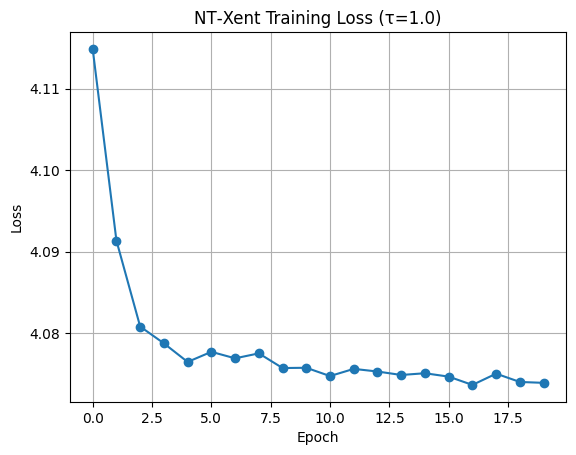

In [13]:
# NT-Xent Loss & Training Loop
# -------------------------------

import torch.nn.functional as F

# Contrastive temperature
tau = 1.0  

def nt_xent_loss(z, v, tau):
    """
    NT-Xent between student embeddings z and victim embeddings v.
    z, v: (B, D) tensors
    Returns: scalar loss
    """
    # normalize
    z_norm = F.normalize(z, dim=1)  # (B, D)
    v_norm = F.normalize(v, dim=1)  # (B, D)
    # similarity matrix: B x B
    logits = torch.matmul(z_norm, v_norm.T) / tau
    # positive pairs are on the diagonal
    labels = torch.arange(z.size(0), device=z.device)
    return F.cross_entropy(logits, labels)

# Prepare training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StolenEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loader = DataLoader(SimCLRDataset(images, reps, simclr_transform), batch_size=64, shuffle=True)
# assume `model`, `optimizer`, `loader` already defined above
num_epochs = 20
history = []

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0

    for t1, t2, yv in loader:
        # we only need one view for victim alignment
        t1, yv = t1.to(device), yv.to(device)

        optimizer.zero_grad()
        z1 = model(t1)   # (B,1024)
        loss = nt_xent_loss(z1, yv, tau)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(loader)
    history.append(avg_loss)
    print(f"[Epoch {epoch}/{num_epochs}] NT‑Xent Loss: {avg_loss:.4f}")

# Plot loss curve
plt.plot(history, marker='o')
plt.title(f"NT‑Xent Training Loss (τ={tau})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


-------------
#### OR

#### SNN loss training loop

c:\Users\srtol\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\srtol\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[Epoch 1/20] SNN Loss: 4.1033
[Epoch 2/20] SNN Loss: 4.0557
[Epoch 3/20] SNN Loss: 4.0356
[Epoch 4/20] SNN Loss: 4.0300
[Epoch 5/20] SNN Loss: 4.0328
[Epoch 6/20] SNN Loss: 4.0297
[Epoch 7/20] SNN Loss: 4.0282
[Epoch 8/20] SNN Loss: 4.0263
[Epoch 9/20] SNN Loss: 4.0249
[Epoch 10/20] SNN Loss: 4.0247
[Epoch 11/20] SNN Loss: 4.0249
[Epoch 12/20] SNN Loss: 4.0270
[Epoch 13/20] SNN Loss: 4.0225
[Epoch 14/20] SNN Loss: 4.0246
[Epoch 15/20] SNN Loss: 4.0221
[Epoch 16/20] SNN Loss: 4.0231
[Epoch 17/20] SNN Loss: 4.0219
[Epoch 18/20] SNN Loss: 4.0218
[Epoch 19/20] SNN Loss: 4.0219
[Epoch 20/20] SNN Loss: 4.0216


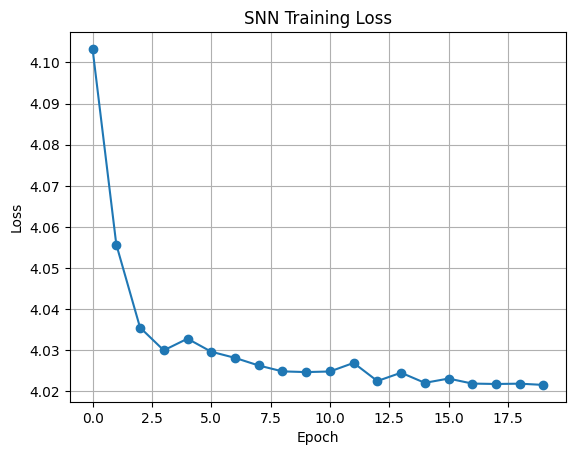

In [10]:
def snn_loss(z, v, tau=0.5):
    # Normalize
    z = F.normalize(z, dim=1)
    v = F.normalize(v, dim=1)

    sim_matrix = torch.mm(z, v.T) / tau  # (B, B)
    positives = torch.exp(torch.diag(sim_matrix))  # numerator
    negatives = torch.exp(sim_matrix).sum(dim=1)  # denominator
    loss = -torch.log(positives / negatives).mean()
    return loss

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StolenEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
dataset = SimCLRDataset(images, reps, simclr_transform)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

num_epochs = 20
history = []

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0

    for t1, t2, yv in loader:
        t1, yv = t1.to(device), yv.to(device)
        z1 = model(t1)

        loss = snn_loss(z1, yv, tau=0.5)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(loader)
    history.append(avg_loss)
    print(f"[Epoch {epoch}/{num_epochs}] SNN Loss: {avg_loss:.4f}")

# Plot training loss
plt.plot(history, marker='o')
plt.title("SNN Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

### Exporting model to ONNX

In [ ]:
import torch.onnx

# ONNX_PATH = "F:\\TML_model_stealing\\TML25_A2_39\\models\\model_Sim_CLR.onnx"           # alpha = 0.5                      L2 = 6.81
# ONNX_PATH = "F:\\TML_model_stealing\\TML25_A2_39\\models\\model_Sim_CLR_07.onnx"        # alpha = 0.7                      L2 = 6.6186
# ONNX_PATH = "F:\\TML_model_stealing\\TML25_A2_39\\models\\model_Sim_CLR_09.onnx"        # alpha = 0.9                      L2 = 6.6148
# ONNX_PATH = "F:\\TML_model_stealing\\TML25_A2_39\\models\\model_Sim_CLR_cosine.onnx"    # alpha = 0.7 _&_ cosine loss      L2 = ?
# ONNX_PATH = "F:\\TML_model_stealing\\TML25_A2_39\\models\\model_Sim_CLR_NT_xent.onnx"   # NT-Xent loss _&_ tau = 1.0       L2 = 35.201
ONNX_PATH = "F:\\TML_model_stealing\\TML25_A2_39\\models\\model_Sim_CLR_SNN.onnx"         # SNN loss                         L2 = ?
dummy_input = torch.randn(1, 3, 32, 32).to(device)

torch.onnx.export(
    model,
    dummy_input,
    ONNX_PATH,
    input_names=["x"],
    output_names=["embedding"],
    export_params=True,
    opset_version=11,
    do_constant_folding=True
)

print(f"\u2705 Exported SimCLR ONNX model to: {ONNX_PATH}")

✅ Exported SimCLR ONNX model to: F:\TML_model_stealing\TML25_A2_39\models\model_Sim_CLR_SNN.onnx


In [1]:
### done